# Numpy-style Reimplementation of `Trans_GreenFunction`
As a result of the comparison, the numpy indexing version is identical to the for-loop version. The for-loop version can be accessed via the `mode='legacy'` parameter.
Using the script with the same name as the current notebook, it was verified that the numpy-style version requires about 35% less computation time.

In [27]:
import logging

log_format = "%(asctime)s [%(threadName)-10.10s] [%(name)-14.14s] [%(levelname)-5.5s]  %(message)s"
logging.basicConfig( #filename='{:%Y-%m-%dT%H%M%S}.log'.format(datetime.now()),
                    level=logging.INFO,
                    format=log_format,)

# child logger for local use
logger = logging.getLogger(__name__ + '.nb')
logger.setLevel(logging.DEBUG)

def printl(*args, sep=' '):
    logging.info(sep.join([str(val) for val in args]) )

In [129]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.constants import e as qelec, epsilon_0 as epsilon0
import math

In [5]:

sys.path.append('../') 

In [7]:
from DWFA_cyl_func_Ng import FindMode, Long_GreenFunction, Trans_GreenFunction, WakePotential, BunchDistG, BunchDistrib, BunchDistU, multimode_trans_greens_function


In [8]:
a = 0.69e-3
b = 1.29e-3
eps_r = 9.6
l_dlw = 0.09


m_range = (1,8)
n_max = 8
# large_al2o3_streaker.find_modes((1,8), 10)
# N_z_wake = 1001

In [9]:

from scipy.special import jnp_zeros
u_11 = jnp_zeros(1,1)[0]
assert m_range[1] > m_range[0] and len(m_range) == 2

m_range = tuple(m_range)
num_m = m_range[1] - m_range[0]
num_n = n_max

mode_ampl = np.empty((num_m, num_n))
mode_wave_vec = np.empty((num_m, num_n))

for m in range(*m_range):
    logger.info(f"Computing {n_max} amplitudes and wavevectors for angular mode number m={m}...")
    mode_ampl[m - m_range[0]], mode_wave_vec[m - m_range[0]] =\
        FindMode(b, a, n=m, epsilon=eps_r, Nmode = n_max, num_k_sampling = 500) 
        ## Old version
        # FindMode(outer_radius, inner_radius, n=m, epsilon=eps_r, Nmode=n_max, 
        #          k_0= u_11/(2*np.pi*outer_radius))

max_wvl = 2*np.pi/np.min(mode_wave_vec)
logger.debug(f"Max. wavelength: {max_wvl:1.2e} m")

2024-07-09 22:44:18,006 [MainThread] [__main__.nb   ] [INFO ]  Computing 8 amplitudes and wavevectors for angular mode number m=1...
2024-07-09 22:44:18,041 [MainThread] [DWFA_cyl_func_] [INFO ]  
    ----- Summary ------
    mode order =1
    Roots:[ 2336.130675    3717.16629328  7384.86699626  8375.70412892
 12371.58365912 13423.4140709  17383.83530015 18569.75782818]
    dDisp:[ 0.83437312 -0.43829695  0.13101157 -0.11469033  0.08116283 -0.0752412
  0.06700684 -0.06344291]
    Mode Amplitudes:[1.54766728e+17 1.27713745e+18 9.46421041e+17 1.20233750e+18
 1.34658268e+18 7.49116520e+17 1.39677066e+18 4.73214599e+17]
    Mode WaveVectors / m^-1 :[ 796.61394831 1267.54318544 2518.2187446  2856.0914025  4218.6750129
 4577.34620636 5927.83863649 6332.23486208]
    Mode Wavelengths /m :[0.00788737 0.00495698 0.00249509 0.00219992 0.00148937 0.00137267
 0.00105995 0.00099225]
    --------------------
2024-07-09 22:44:18,041 [MainThread] [__main__.nb   ] [INFO ]  Computing 8 amplitudes and wa

In [10]:
r_offset = 0.45e-3
N_z = 1001

kwargs= {
        "r0" : r_offset, "r": r_offset, 
        "b": a, "a" : b,
        "zmin": 0, "zmax" : max_wvl,
        "Nz": N_z , "epsilon": eps_r
    }
m = 1
# for m in range(*m_range):
kwargs["RootAmplit"] = mode_ampl[m - m_range[0]]
kwargs["RootWavVec"] = mode_wave_vec[m - m_range[0]]
kwargs["n"] = m
z, w_t = Trans_GreenFunction(**kwargs)

In [11]:
%%timeit -r 10 -n 10
z, w_t = Trans_GreenFunction(**kwargs)

195 µs ± 104 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


Text(0, 0.5, 'wake potential function / V/C')

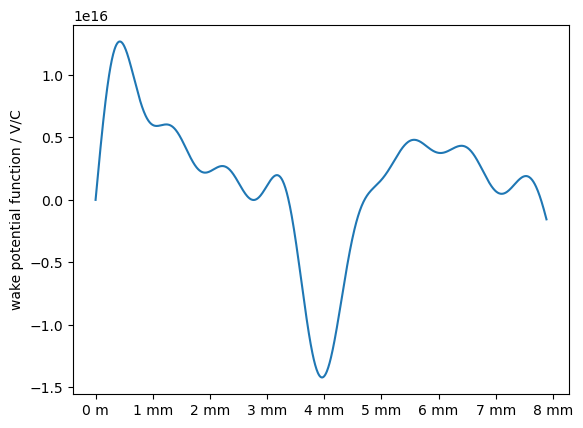

In [12]:
fig, ax = plt.subplots()
ax.plot(z, w_t)
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='m'))
ax.set_ylabel('wake potential function / V/C')

In [13]:
kwargs["RootAmplit"]

array([1.54766728e+17, 1.27713745e+18, 9.46421041e+17, 1.20233750e+18,
       1.34658268e+18, 7.49116520e+17, 1.39677066e+18, 4.73214599e+17])

In [14]:
from scipy.constants import e as qelec, epsilon_0
import math

In [15]:
zz=np.linspace(kwargs['zmin'], kwargs['zmax'], kwargs['Nz'])
n=m

WakeGreen=0.0*zz
Nmode=len(kwargs["RootAmplit"])
F_=np.zeros(Nmode)
NormalizationCGS2SI=qelec*qelec/(b*b)*  (r_offset/b)**n  *(r_offset/b)**(n-1)  *8.0*n*np.sqrt(eps_r-1.0)/(a/b)**(2.0*n) /(4*math.pi*epsilon_0)


In [28]:
NormalizationCGS2SI

3.965756348875762e-21

In [19]:
# %%timeit -r 10 -n 10
WakeGreen = np.sum((kwargs["RootAmplit"]/(kwargs["RootWavVec"]*np.sqrt(eps_r * 1 - 1.0)*b))[:, np.newaxis] * np.sin(np.outer(kwargs["RootWavVec"], zz)), axis=0)
WakeGreen *= NormalizationCGS2SI/qelec

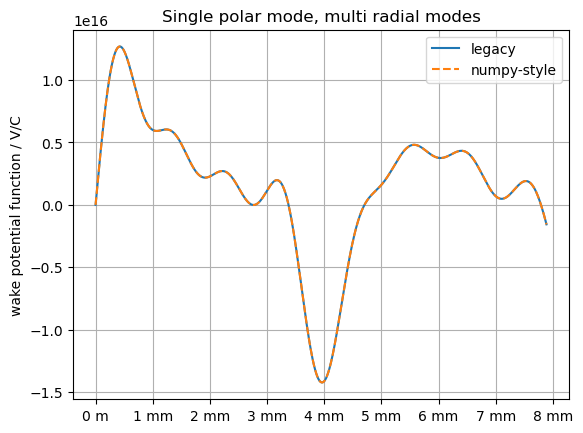

In [96]:
fig, ax = plt.subplots()
ax.plot(zz, WakeGreen, label='legacy')
ax.plot(z, w_t, '--', label = 'numpy-style')
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='m'))
ax.set_ylabel('wake potential function / V/C')
ax.set_title('Single polar mode, multi radial modes')
ax.legend()
ax.grid()

In [26]:
np.all(np.isclose(w_t, WakeGreen))

True

In [97]:
z_multi, wake_multi = multimode_trans_greens_function(mode_ampl, mode_wave_vec, m_modes=np.arange(*m_range), r0=r_offset, r=r_offset, theta=0,
                                zmin= kwargs['zmin'], zmax = kwargs['zmax'], Nz = kwargs['Nz'], b=a, a=b, epsilon=eps_r)

In [110]:
theta= np.deg2rad(10)
np.cos(m_set * theta) * NormalizationCGS2SI

array([3.90550760e-21, 3.17006879e-21, 1.86393862e-21, 9.35019190e-22,
       4.17129508e-22, 1.65608077e-22, 5.62130085e-23])

In [109]:
np.sin(np.multiply.outer(mode_wave_vec, zz)).shape

(7, 8, 1001)

In [100]:
m_set = np.arange(*m_range)
NormalizationCGS2SI = qelec*qelec/(b*b)*  (r_offset/b)**m_set  *(r_offset/b)**(m_set-1)  *8.0* m_set *np.sqrt(eps_r-1.0)/(a/b)**(2.0*m_set) /(4*math.pi*epsilon_0)
temp = (((mode_ampl/(mode_wave_vec*np.sqrt(eps_r * 1 - 1.0)*b))[:, :, np.newaxis]) * np.sin(np.multiply.outer(mode_wave_vec, zz)))
# transverse_wake = NormalizationCGS2SI[:, np.newaxis, np.newaxis] * temp 

transverse_wake = np.sum(
    NormalizationCGS2SI[:, np.newaxis] * np.sum(temp, axis=1),
      axis=0)
transverse_wake /= qelec


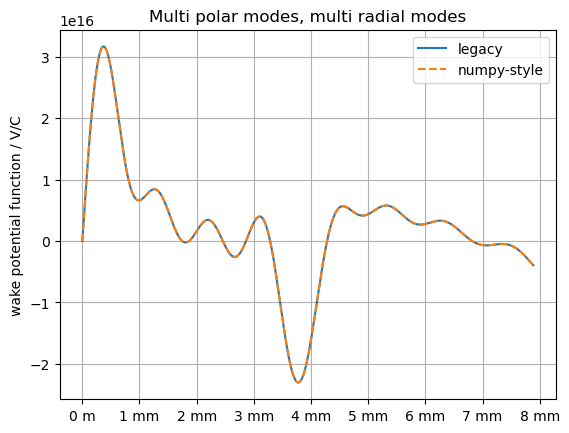

In [101]:
fig, ax = plt.subplots()
ax.plot(z_multi, wake_multi, label='legacy')
ax.plot(zz, transverse_wake, '--', label = 'numpy-style')
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='m'))
ax.set_ylabel('wake potential function / V/C')
ax.set_title('Multi polar modes, multi radial modes')
ax.legend()
ax.grid()

In [105]:
multimode_trans_greens_function(mode_ampl, mode_wave_vec, m_modes = np.arange(1,8), 
     r0=0.45e-3, r= 0.4e-3, theta= np.deg2rad(10), 
     zmin= 0, zmax=10e-3, Nz=6, 
     b = 0.69e-3, a= 1.29e-3, epsilon= 9.6)

(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 ]),
 array([ 0.00000000e+00,  1.62490024e+15, -1.67036058e+16,  2.84819256e+15,
        -5.01866119e+15,  3.10961432e+14]))

In [115]:
raise NotImplementedError

NotImplementedError: 

# Implementing `multimode_multipos_trans_greens_function`

In [178]:
current_offset = 0.5e-3
r_array = np.linspace(-100e-6, 100e-6, 5) + current_offset
r_array

array([0.0004 , 0.00045, 0.0005 , 0.00055, 0.0006 ])

In [188]:
# Required parameters: RootAmplit, RootWavVec, m_modes, r_source, r_trailing, z_pos, b, a, epsilon
RootAmplit = mode_ampl
RootWavVec = mode_wave_vec
m_modes=m_set
r_source = r_array
r_trailing = r_array
# r_trailing = np.linspace(-100e-6, 100e-6, 10)  # only for debug
z_pos = np.linspace(0, max_wvl, 1001)
b= kwargs['b']
a=kwargs['a']
epsilon = kwargs['epsilon']
mu_r = 1

In [189]:
# NormalizationCGS2SI = qelec*qelec/(a * a)*  (r0/a)** m_modes  * (r/a)**(m_modes - 1)  *8.0* m_modes *np.sqrt(epsilon-1.0)/(b/a)**(2.0*m_modes) /(4*math.pi*epsilon0)   # shape (Mmode,)
NormalizationCGS2SI = qelec*qelec/(a * a)*                                               8.0* m_modes *np.sqrt(epsilon-1.0)/(b/a)**(2.0*m_modes) /(4*math.pi*epsilon0)   # shape (Mmode,)
NormalizationCGS2SI = qelec*qelec/(a * a)*np.sqrt(epsilon-1.0) * 8.0/(4*math.pi*epsilon0)   # shape ()
prefactor_m_dependent =  m_modes /(b/a)**(2.0*m_modes)    # shape (Mmode,)  , m-dependent prefactor in Eq. (5.4)
# TODO: in principle, `prefactor_m_dependent` can be extended for the angles by np.cos(m_modes * theta)
power_factors = (
    np.power.outer(r_source/a, m_modes)[:, np.newaxis, :] * 
    np.power.outer(r_trailing/a, m_modes-1)[np.newaxis,:,:]
)  # shape (Nr, Nrt, Nmode)

NormalizationCGS2SI.shape, prefactor_m_dependent.shape, power_factors.shape

((), (7,), (5, 5, 7))

In [190]:
WakeGreen_summands_per_m_mode = (
            ((RootAmplit/(RootWavVec*np.sqrt(epsilon * mu_r - 1.0)*a))[:, :, np.newaxis]) *  # shape (Mmode, Nmode, 1)
            np.sin(np.multiply.outer(RootWavVec, z_pos)))                                       # shape (Mmode, Nmode, Nz)
# summation over the radial mode index
WakeGreen_per_m_mode = np.sum(WakeGreen_summands_per_m_mode, axis=1) # shape (Mmode, Nz)

In [191]:
# each z-position must be multiplied by the prefactor which depends on the source radial position, on the trailing radial position, and the angular mode index m
transverse_wake_func_2d = np.sum((prefactor_m_dependent * power_factors)[:, :, :, np.newaxis] * WakeGreen_per_m_mode,  # shape (Nr, Nrt, Nmode, Nz)
       axis=2)   # summation over mode index m
transverse_wake_func_2d *= (NormalizationCGS2SI/qelec)

In [216]:
idx_r_s = 2
idx_r_t = 4 
r_source[idx_r_s], r_trailing[idx_r_t]

(0.0005, 0.0006000000000000001)

In [217]:
z_multi, wake_multi = multimode_trans_greens_function(mode_ampl, mode_wave_vec, m_modes = m_modes, 
     r0=r_source[idx_r_s], r= r_trailing[idx_r_t], theta= np.deg2rad(0), 
     zmin= z_pos[0], zmax= z_pos[-1], Nz= z_pos.shape[0], 
     b = 0.69e-3, a= 1.29e-3, epsilon= 9.6)

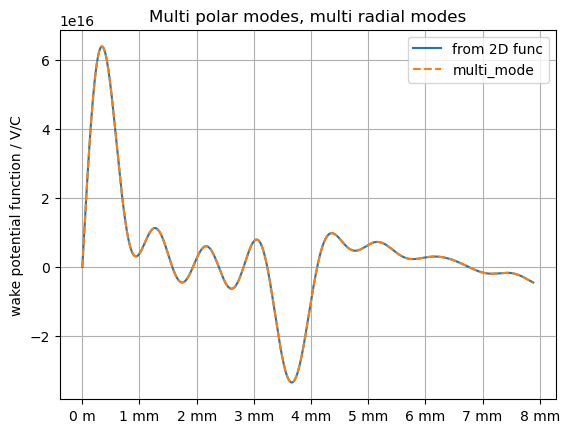

In [218]:
fig, ax = plt.subplots()
ax.plot(z_pos, transverse_wake_func_2d[idx_r_s, idx_r_t, :], label='from 2D func')
ax.plot(z_multi, wake_multi, '--', label = 'multi_mode')
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='m'))
ax.set_ylabel('wake potential function / V/C')
ax.set_title('Multi polar modes, multi radial modes')
ax.legend()
ax.grid()

In [219]:
np.all(np.isclose(transverse_wake_func_2d[idx_r_s, idx_r_t, :], wake_multi))

True